In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('notebook')

In [6]:
os.chdir('/home/walml/repos/zoobot')  # for me only

# Human Classifications

### Load the data

In [7]:
dr5_loc = 'dr5_volunteer_catalog.csv'  # update to point to your decals-dr5 csv
dr5 = pd.read_csv(dr5_loc)

The raw responses are recorded in columns named like `some-question_some-answer`. For example:

In [8]:
dr5.head()['smooth-or-featured_featured-or-disk']  # show the data in the first 5 rows only, under the column with that name

0    23
1     2
2     4
3     6
4     3
Name: smooth-or-featured_featured-or-disk, dtype: int64

We've precalculated some useful features like `_total-votes`, `_fraction`, `_fraction-debiased`, etc. For example:

Text(0.5, 0, 'Featured or Disk fraction')

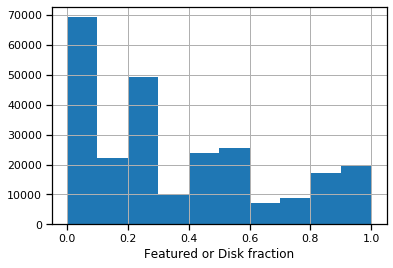

In [9]:
dr5['smooth-or-featured_featured-or-disk_fraction'].hist()
plt.xlabel('Featured or Disk fraction')

Text(0.5, 0, 'Smooth or Featured total votes')

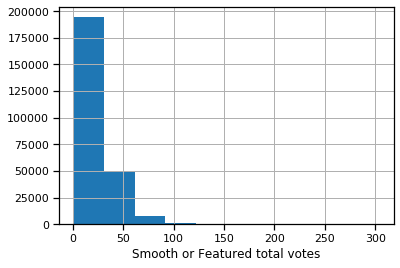

In [10]:
dr5['smooth-or-featured_total-votes'].hist()
plt.xlabel('Smooth or Featured total votes')

Notice how galaxies can have very different total votes! More on this below.

### Upload Groups

Before we start using the data, it's important to understand where it comes from.  

(copy from paper)

In [11]:
dr5['upload_group'].value_counts()

active_baseline    192557
pre_active          51994
active_priority      6939
targeted             1145
calibration           651
Name: upload_group, dtype: int64

In [12]:
pre_active_galaxies = dr5.query('upload_group == "pre_active"')
active_priority_galaxies = dr5.query('upload_group == "active_priority"')
active_random_galaxies = dr5.query('upload_group == "active_random"')


Priority galaxies are generally more featured:

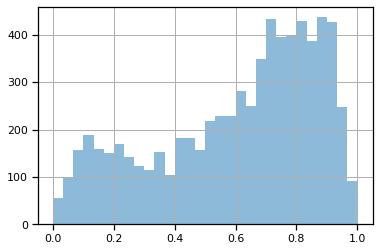

In [13]:
_, bins = np.histogram(np.linspace(0., 1.), bins=30)  # a little trick to get fixed bin intervals
active_priority_galaxies['smooth-or-featured_featured-or-disk_fraction'].hist(bins=bins, alpha=0.5, label='Priority')
active_random_galaxies['smooth-or-featured_featured-or-disk_fraction'].hist(bins=bins, alpha=0.5, label='Random')

Priority galaxies or pre-active-learning galaxies all recieve at least 40 classifications, while random galaxies recieve around 5.

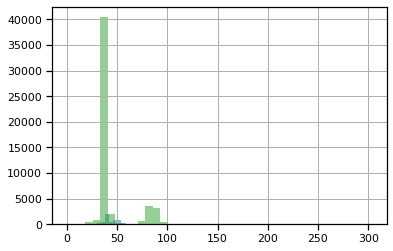

In [14]:
active_priority_galaxies['smooth-or-featured_total-votes'].hist(bins=40, alpha=0.5, label='Priority')
active_random_galaxies['smooth-or-featured_total-votes'].hist(bins=40, alpha=0.5, label='Random')
pre_active_galaxies['smooth-or-featured_total-votes'].hist(bins=40, alpha=0.5, label='Pre')

### Selecting a Galaxy Sample - Human Edition



1. Do I need a random sample?

2. How many responses should my galaxies have?


Pick an upload group

Crossmatch against the galaxies you're interested in.

astropy....



Say I'm interested in all the clearly spiral galaxies:

In [15]:
in_pre_active = dr5['upload_group'] == 'pre_active'  # say I want a random sample
high_spiral_frac = dr5['has-spiral-arms_yes'] > 0.75  # and 75% of volunteers to have said spiral
many_spiral_votes = dr5['has-spiral-arms_total-votes'] > 35  # and plenty of people to have answered the question, for high confidence

demo_sample = dr5[in_pre_active & high_spiral_frac & many_spiral_votes]  # select rows where all conditions are True
print(f'Selected {len(demo_sample)} of {len(dr5)} galaxies')

Selected 3216 of 253286 galaxies




### Science!

Masters et al used GZ2 data to show that, unlike the classic Hubble sequence, spiral winding and bulge size are not strongly correlated. We can use our sample to see if that holds up with our deeper DECaLS data.


In [17]:
in_pre_active = dr5['upload_group'] == 'pre_active'  # we want a random sample with N > 40
featured = dr5['smooth-or-featured_featured-or-disk_fraction'] > 0.43
not_edge_on = dr5['disk-edge-on_no_fraction'] > 0.715
spiral = dr5['has-spiral-arms_yes_fraction'] > 0.619

not_weird = dr5['merging_none_fraction'] > 0.5

df = dr5[in_pre_active & featured & not_edge_on & spiral & not_weird]
print(f'Selected {len(df)} of {len(dr5)} galaxies')

Selected 5378 of 253286 galaxies


In [18]:
def add_masters_derived_columns(df): 
    df['winding_eqn_1'] = df['spiral-winding_tight_fraction'] + 0.5 * df['spiral-winding_medium_fraction']
    df['bulge_eqn_3'] = 0.25 * df['bulge-size_small_fraction'] + 0.5 * df['bulge-size_moderate_fraction'] + 0.75 * df['bulge-size_large_fraction'] + df['bulge-size_dominant_fraction']
     # modifies df inplace

In [19]:
def show_bulge_vs_winding_trend(df):
    fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))
    sns.kdeplot(df['bulge_eqn_3'], df['winding_eqn_1'], ax=ax0)
    sns.scatterplot(df['bulge_eqn_3'], df['winding_eqn_1'], s=50, edgecolor="b", linewidth=.5, marker='+', ax=ax1, alpha=.1)
    ax0.set_xlim([0, 1])
    ax0.set_ylim([0, 1])
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax0.set_ylabel(r'$W_{avg}$')
    ax0.set_xlabel(r'$B_{avg}$')
    ax1.set_xlabel(r'$B_{avg}$')

    # optional -fit a trend line (requires pip install statsmodels)
    # import statsmodels.api as sm
    # z = sm.nonparametric.lowess(df['bulge_eqn_3'], df['winding_eqn_1'])
    # ax1.plot(z[:, 1], z[:, 0], c='r', label='Bulge Fit')
    # ax1.legend()

In [20]:
add_masters_derived_columns(df)

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


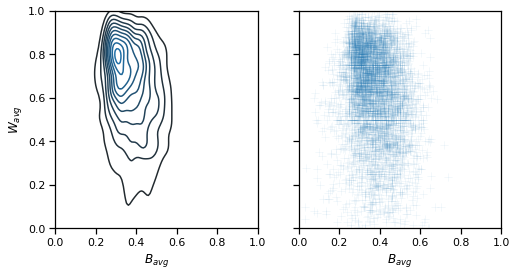

In [21]:
show_bulge_vs_winding_trend(df)

Looks like DECaLS supports Masters et al - using the responses of GZ volunteers, we find the same lack of a clear correlation between spiral winding and bulge size.

# Automated Classifications

So far, we looked at the volunteer responses. GZ DECaLS also includes automatic morphology measurements using machine learning. 

Let's see how to load and use the ML predictions, and then compare with the volunteers.


Load the ML predictions as a DataFrame:

In [22]:

ml = pd.read_parquet('gz_decals_auto_posteriors.parquet')
print('Galaxies with ML predictions: ' + str(len(ml)))

Galaxies with ML predictions: 313789


In [45]:
assert all(dr5['iauname'].isin(ml['iauname']))

In [23]:
sns.set_context('notebook')

In [47]:
add_masters_derived_columns(ml)

Selected 43672 of 313789 galaxies (0.13917632549260808)


/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


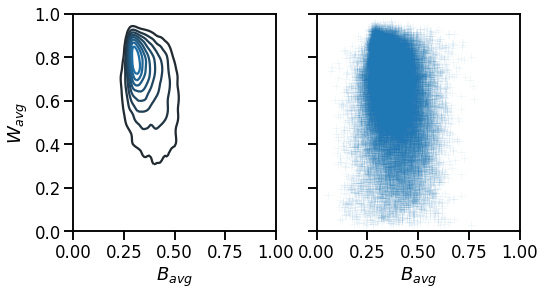

In [48]:

featured = ml['smooth-or-featured_featured-or-disk_fraction'] > 0.43
not_edge_on = ml['disk-edge-on_no_fraction'] > 0.715
spiral = ml['has-spiral-arms_yes_fraction'] > 0.619

not_weird = ml['merging_none_fraction'] > 0.5

ml_sample = ml[featured & not_edge_on & spiral & not_weird]
print(f'Selected {len(ml_sample)} of {len(ml)} galaxies ({len(ml_sample) / len(ml)})')

add_masters_derived_columns(ml_sample)
show_bulge_vs_winding_trend(ml_sample)

Looks very similar, only with more galaxies. Let's compare the volunteer and ML predictions directly.

In [49]:
sns.set_context('talk')

In [65]:
gridsize = 50
mincnt = 2

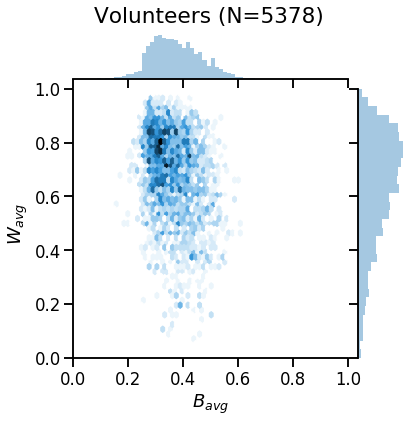

In [70]:
g = sns.jointplot(df['bulge_eqn_3'], df['winding_eqn_1'], kind='hex', gridsize=gridsize, mincnt=mincnt, xlim=[0., 1.], ylim=[0., 1.])  # volunteers
g.ax_joint.set_xlabel(r'$B_{avg}$')
g.ax_joint.set_ylabel(r'$W_{avg}$')
g.fig.suptitle(f"Volunteers (N={len(df)})")
g.fig.subplots_adjust(top=0.92) # Reduce plot to make room 

In [71]:
g.savefig('bulge_winding_corr_humans_final.pdf')

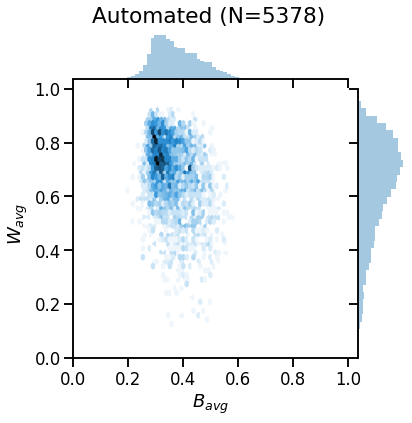

In [72]:
# ml_equal_num = ml_sample.sample(len(df))
# ml_equal_num = ml_sample[ml_sample['iauname'].isin(df['iauname'])]
ml_equal_num = ml[ml['iauname'].isin(df['iauname'])]
g = sns.jointplot(ml_equal_num['bulge_eqn_3'], ml_equal_num['winding_eqn_1'], kind='hex',gridsize=gridsize, mincnt=mincnt, xlim=[0., 1.], ylim=[0., 1.])  # equal size ml-predicted sample
g.ax_joint.set_xlabel(r'$B_{avg}$')
g.ax_joint.set_ylabel(r'$W_{avg}$')
g.fig.suptitle(f"Automated (N={len(ml_equal_num)})")
g.fig.subplots_adjust(top=0.92) # Reduce plot to make room 

In [73]:
g.savefig('bulge_winding_corr_ml_limited_final.pdf')

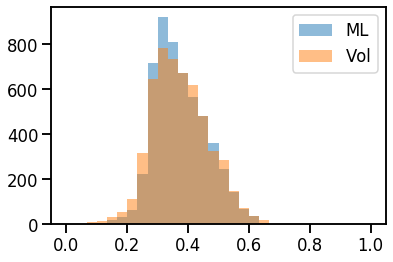

In [74]:
_, bins = np.histogram(np.linspace(0., 1.), bins=30)
plt.hist(ml_equal_num['bulge_eqn_3'], alpha=.5, label='ML', bins=bins)
plt.hist(df['bulge_eqn_3'], alpha=.5, label='Vol', bins=bins)
plt.legend()

Definitely consistent. Of course, we have ML predictions for many more galaxies, and when we include all of them, our distribution of bulge size and winding becomes even clearer.

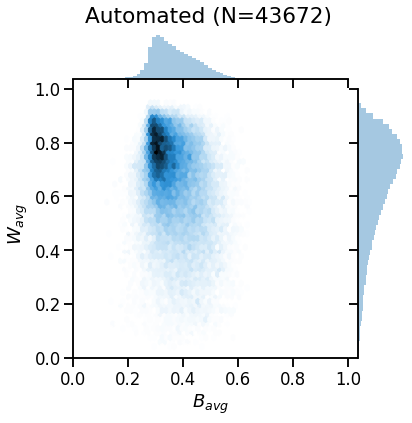

In [75]:
g = sns.jointplot(ml_sample['bulge_eqn_3'], ml_sample['winding_eqn_1'], kind='hex', gridsize=gridsize, mincnt=mincnt, xlim=[0., 1.], ylim=[0., 1.])
g.ax_joint.set_xlabel(r'$B_{avg}$')
g.ax_joint.set_ylabel(r'$W_{avg}$')
g.fig.suptitle(f"Automated (N={len(ml_sample)})")
g.fig.subplots_adjust(top=0.92) # Reduce plot to make room 

In [76]:
g.savefig('bulge_winding_corr_ml_final.pdf')